# Analyzing SAT scores of New York in 2012
### Introduction
The SAT is an entrance exam used by most colleges and universities to make admission decisions. This is a multi-choice, pencil and paper test managed by the College Board.
The purpose of the SAT is to measure the preparation of high school students for the university and to provide the university with a common data point that can be used to compare all applicants. University Admissions Officers will review standardized test scores with the high school GPA, high school curriculum, teacher or tutor recommendation letters, extracurricular activities, admissions interviews and personal papers. The importance of SAT scores in the university application process varies from school to school.
### Data sources
This dataset is from New York open data and provided by Department of Education. It indicated the most recent school level results for New York City on the SAT. Results are available at the school level for the graduating seniors of 2012. Records contain 2012 College-bound seniors mean SAT scores taken during SY 2012.
### Questions to answer
* What's the situation of SAT scores of New York in 2012?
* Is there any relationships between total scores and scores of different parts?
* Could we use critical reading part to predict the rank of the total socre?

### Setting up the environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import sklearn
import sklearn.metrics
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import random
from sklearn.metrics import accuracy_score

### Data extraction
We downloaded the data from New York Open data and uploaded to the dropbox. According to the link, we can directly download the original dataset.

In [2]:
sat = pd.read_csv('https://www.dropbox.com/s/1vjvwso83jlvafd/2012_SAT_Results.csv?dl=1')
sat.head(10)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384
5,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHOOL,112,332,557,316
6,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522,574,525
7,01M650,CASCADES HIGH SCHOOL,18,417,418,411
8,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624,604,628
9,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395,400,387


### Data Cleaning
* Rename the columns
* Delete the rows with null values
* convert the datatype from object to integral
* create the new column of total scores
* describe the data

In [3]:
sat.rename(columns={'DBN':'ID',
                   'SCHOOL NAME':'School',
                   'Num of SAT Test Takers':'num_test_takers',
                   'SAT Critical Reading Avg. Score':'cr_mean_score',
                   'SAT Math Avg. Score':'math_mean_score',
                   'SAT Writing Avg. Score':'write_mean_score'}, inplace = True)
sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
ID                  478 non-null object
School              478 non-null object
num_test_takers     478 non-null object
cr_mean_score       478 non-null object
math_mean_score     478 non-null object
write_mean_score    478 non-null object
dtypes: object(6)
memory usage: 22.5+ KB


In [4]:
sat = sat[sat.num_test_takers != 's']

In [5]:
sat['num_test_takers'] = sat['num_test_takers'].astype(int)
sat['cr_mean_score'] = sat['cr_mean_score'].astype(int)
sat['math_mean_score'] = sat['math_mean_score'].astype(int)
sat['write_mean_score'] = sat['write_mean_score'].astype(int)
sat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 477
Data columns (total 6 columns):
ID                  421 non-null object
School              421 non-null object
num_test_takers     421 non-null int64
cr_mean_score       421 non-null int64
math_mean_score     421 non-null int64
write_mean_score    421 non-null int64
dtypes: int64(4), object(2)
memory usage: 23.0+ KB


In [6]:
sat['sum_score'] = sat['cr_mean_score'] + sat['math_mean_score'] + sat['write_mean_score']

In [7]:
sat.describe()

,num_test_takers,cr_mean_score,math_mean_score,write_mean_score,sum_score
count,421.000000,421.000000,421.000000,421.000000,421.000000
mean,110.320665,400.850356,413.368171,393.985748,1208.204276
std,155.534254,56.802783,64.684655,58.635109,174.536123
min,6.000000,279.000000,312.000000,286.000000,887.000000
25%,41.000000,368.000000,371.000000,360.000000,1102.000000
50%,62.000000,391.000000,395.000000,381.000000,1169.000000
75%,95.000000,416.000000,437.000000,411.000000,1257.000000
max,1277.000000,679.000000,735.000000,682.000000,2096.000000


* From the description above, we could see that the average scores of different parts are around 400. What's more, the total socres of 1275 is in the 75th, which can be defined as high level.

### Data visualization
In this section, we will show the situation of SAT scores by using the histogram, boxplot.
* Histogram
All histograms shows a positive-skewed distribution. Also, three parts indicated a similar mean, approxiamately 400. What's more, there are few test takers having high scores, above 650, in three parts.


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


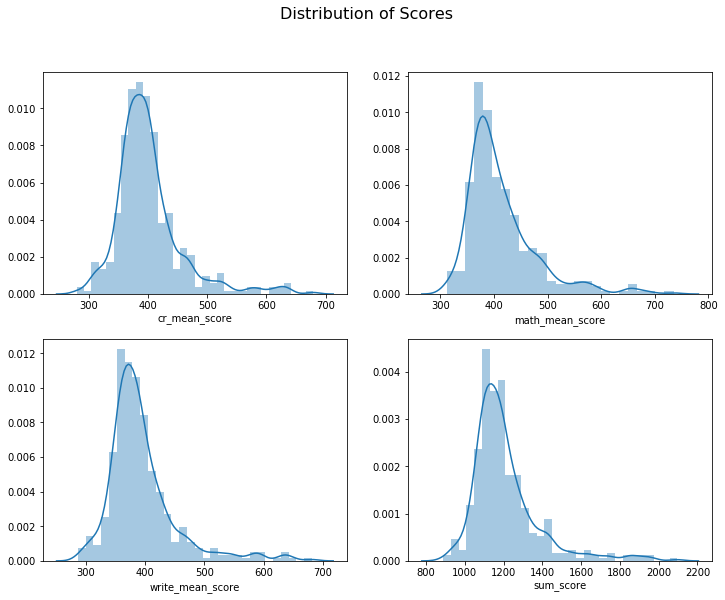

In [8]:
fig, axarr = plt.subplots(2, 2, figsize=(12, 9))
axarr = axarr.flatten()
fig.suptitle('Distribution of Scores', fontsize=16)
sns.distplot(sat['cr_mean_score'],ax = axarr[0])
sns.distplot(sat['math_mean_score'],ax = axarr[1])
sns.distplot(sat['write_mean_score'],ax = axarr[2])
sns.distplot(sat['sum_score'],ax = axarr[3])

* Boxplot
Three boxplots also showed a similar average scores and a similar IQR. In writing and math part, there are zero outlers in the lowest zone. Besides, in critical reading part, there are zero test takers taking above 700 while the full credict is 800.

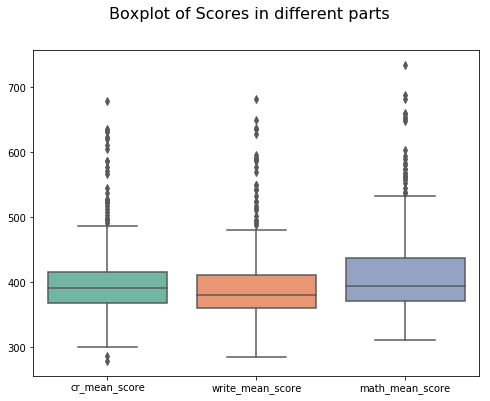

In [9]:
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle('Boxplot of Scores in different parts', fontsize=16)
sns.boxplot(data=sat[['cr_mean_score','write_mean_score','math_mean_score']], orient="v", palette="Set2")

### Descritive statistics
In this section, we are goint to create the heatmap and regression plot to show the relationship between total scores and scores of different part.
* In the heatmap, we also included a variables, the number of test takers, since we assumed that the number of test takers could have a effect on the average of total scores. We can see that except the number of test takers, three parts of the test have a high correlation with the total scores, all above 0.95.

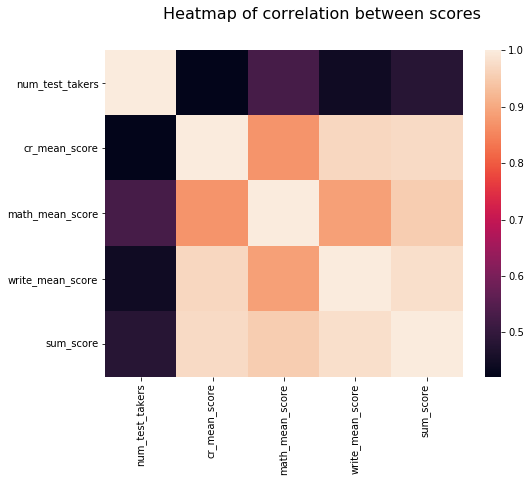

,num_test_takers,cr_mean_score,math_mean_score,write_mean_score,sum_score
num_test_takers,1.000000,0.421818,0.528985,0.444447,0.482639
cr_mean_score,0.421818,1.000000,0.872412,0.970342,0.974758
math_mean_score,0.528985,0.872412,1.000000,0.888456,0.953011
write_mean_score,0.444447,0.970342,0.888456,1.000000,0.981016
sum_score,0.482639,0.974758,0.953011,0.981016,1.000000


In [10]:
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle('Heatmap of correlation between scores', fontsize=16)
corr = sat.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()
corr

* The regression plot also proved the conclusion mentioned above, indicating a smooth and positive relationship between total score and scores of different parts. Besides, since the writing part has the greatest correlation, 0.98, it is the best part to interpet the total scores.

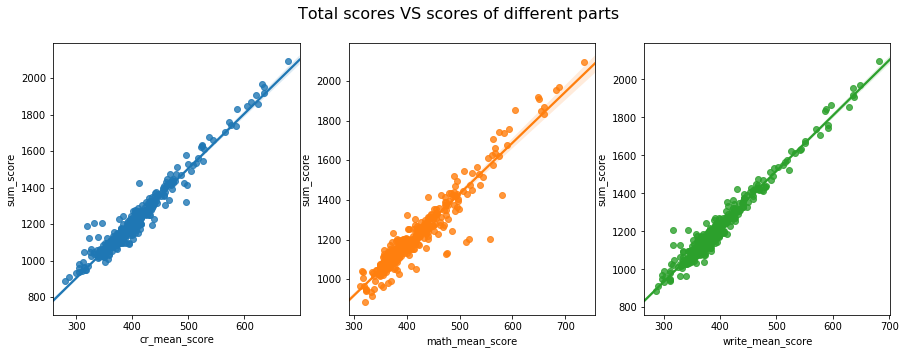

In [11]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Total scores VS scores of different parts', fontsize=16)
sns.regplot(x = "cr_mean_score", y = "sum_score", data = sat,ax=axarr[0])
sns.regplot(x = "math_mean_score", y = "sum_score", data = sat,ax=axarr[1])
sns.regplot(x = "write_mean_score", y = "sum_score", data = sat,ax=axarr[2])

### Classification
In this section, we are going to use critical reading part to predict the rank of the total socre. Let's first look through the description of the data. In the 75th rank, the total score is 1257, so I decided to set up a seperate line in 1250. When the total score is greater than 1250, we defined the score is high. And when the total score is less or equal to the 1250, it is defined low.

#### Classification using Sklearn's RandomForestClassifier

In [12]:
sat.describe()

,num_test_takers,cr_mean_score,math_mean_score,write_mean_score,sum_score
count,421.000000,421.000000,421.000000,421.000000,421.000000
mean,110.320665,400.850356,413.368171,393.985748,1208.204276
std,155.534254,56.802783,64.684655,58.635109,174.536123
min,6.000000,279.000000,312.000000,286.000000,887.000000
25%,41.000000,368.000000,371.000000,360.000000,1102.000000
50%,62.000000,391.000000,395.000000,381.000000,1169.000000
75%,95.000000,416.000000,437.000000,411.000000,1257.000000
max,1277.000000,679.000000,735.000000,682.000000,2096.000000


* Create a new column showing the class of total socres. 1 is for high, while 0 is for low.

In [13]:
sat['class_sum_score'] = sat['sum_score']
sat.head(10)

,ID,School,num_test_takers,cr_mean_score,math_mean_score,write_mean_score,sum_score,class_sum_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,1122,1122
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,1172,1172
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370,1149,1149
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359,1174,1174
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384,1207,1207
5,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHOOL,112,332,557,316,1205,1205
6,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522,574,525,1621,1621
7,01M650,CASCADES HIGH SCHOOL,18,417,418,411,1246,1246
8,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624,604,628,1856,1856
9,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395,400,387,1182,1182


* The first step is to convert the scores which are over 1250 into 1 and then the scores which are less than 1250 will not equal to 1. Therefore, we used this logic to divide the total score into 2 classes.


In [14]:
sat.class_sum_score[sat.class_sum_score > 1250] = 1
sat.class_sum_score[sat.class_sum_score != 1] = 0
sat['class_sum_score'] = sat['class_sum_score'].astype(np.int64)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
print(sat.info())
print(sat.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 477
Data columns (total 8 columns):
ID                  421 non-null object
School              421 non-null object
num_test_takers     421 non-null int64
cr_mean_score       421 non-null int64
math_mean_score     421 non-null int64
write_mean_score    421 non-null int64
sum_score           421 non-null int64
class_sum_score     421 non-null int64
dtypes: int64(6), object(2)
memory usage: 29.6+ KB
None
       ID                                             School  num_test_takers  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES               29   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL               91   
2  01M450                         EAST SIDE COMMUNITY SCHOOL               70   
3  01M458                          FORSYTH SATELLITE ACADEMY                7   
4  01M509                            MARTA VALLE HIGH SCHOOL               44   
5  01M515            LOWER EAST SIDE PRE

In [16]:
CR = sat[['cr_mean_score']]
Class = sat[['class_sum_score']]
random.seed(123)
CR_train, CR_test, Class_train, Class_test = sklearn.model_selection.train_test_split(CR, Class, test_size=0.3)

In [17]:
model = sklearn.ensemble.RandomForestClassifier(n_estimators=1)
result = model.fit(CR_train,Class_train)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [18]:
preds = result.predict(CR_test)
print(accuracy_score(Class_test, preds))

0.952755905511811


In [19]:
print(sklearn.metrics.classification_report(Class_test, preds))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97        95
          1       0.91      0.91      0.91        32

avg / total       0.95      0.95      0.95       127



* We could see the the precision and recall of our model are 0.95, meaning this is a good model which can be applied into the new data.

### Conclusion
* From the description of the data, we can see the average of SAT scores of New York in 2012 is 1208,which is just a medium level since top 50 universities all require 1800 and even more. Based on the information above, 75% of New York students' scores are far from this requirement.
* What's more, since we construct the classification model, we can use the critical reading part to predict the rank of the students and the universities which focus on this part could make a decision of admission by using this model.